# How to Tune Machine Learning Algorithm with scikit-learn
This notebook includes 
- how to do grid search and cross-validation on machine learning algorithm to boost performance (decision tree and random forest)

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

## 1. MNIST Dataset
Reuse previous dataset preparation code.

In [2]:
def build_dataset(dtype, visualize=False):
    if dtype == 'iris':
        from sklearn.model_selection import train_test_split
        from sklearn.datasets import load_iris
        iris = load_iris()
        X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target)
        
        if visualize:
            import pandas as pd
            iris_df = pd.DataFrame(X_train, columns=iris.feature_names)
            #pd.plotting.scatter_matrix(iris_df, c=y_train, s=60, alpha=0.8)
            def target2color(target):
                color = ['r', 'g', 'b'] # setosa, versicolor, virginica
                return color[target]
            col = list(map(target2color, y_train))
            iris_df.plot.scatter(x='petal length (cm)', y='petal width (cm)', c=col)
    elif dtype == 'mnist':
        from sklearn.datasets import fetch_openml
        
        mnist = fetch_openml('mnist_784')
        n_train = 60000
        X_train, X_test = mnist.data[:n_train], mnist.data[n_train:]
        y_train, y_test = mnist.target[:n_train], mnist.target[n_train:]
        
        if visualize:
            id = 0
            plt.figure()
            plt.imshow(X_train[id].reshape(28, 28))
            plt.title('class {}'.format(y_train[id]))
    else:
        raise NotImplementedError
    return X_train, y_train, X_test, y_test

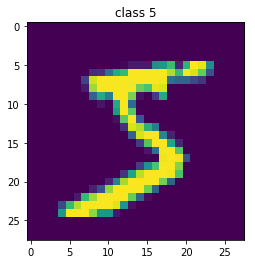

In [3]:
_ = build_dataset('mnist', visualize=True)

## 2. Grid Search with Cross Validation
Define candidates for parameter search and wrap classifier model with GridSearchCV.
Also code for trainig/evalution is modified slightly to apply the best model. 
Parameters for DecisionTreeClassifier can be found in https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html.

In [4]:
def build_model(mtype, grid_search=False):
    if mtype == 'tree':
        from sklearn.tree import DecisionTreeClassifier
        param_grid=[{
            'criterion': ['gini', 'entropy'],
            'splitter': ['best', 'random'],
            'max_depth': [None, 10],
            }]
        clf = DecisionTreeClassifier()
    elif mtype == 'forest':
        from sklearn.ensemble import RandomForestClassifier
        param_grid=[{
            #'criterion': ['gini', 'entropy'],
            'bootstrap': [True, False],
            'warm_start': [True, False],
            #'max_features': ['auto', 'sqrt', 'log2'],
            }]
        clf = RandomForestClassifier()
    else:
        raise NotImplementedError
    
    if grid_search:
        from sklearn.model_selection import GridSearchCV
        clf = GridSearchCV(clf, param_grid, cv=5, verbose=2, n_jobs=-1)
    return clf

In [5]:
def istrue(dic, attr):
    return attr in dic and dic[attr]

def train_sklearn(config={}):
    X_train, y_train, X_test, y_test = build_dataset(config['dataset'])
    clf = build_model(config['model'], istrue(config, 'grid_search'))
    #print(clf)
    clf.fit(X_train, y_train)
    if istrue(config, 'grid_search'):
        print('best param: {}, val accuracy: {}'.format(clf.best_params_, clf.best_score_))
        clf = clf.best_estimator_
    test_acc = clf.score(X_test, y_test)
    #prediction = clf.predict(X_test)
    #test_acc = (prediction == y_test).mean()
    print('test accuracy: {}'.format(test_acc))
    
    if istrue(config, 'visualize'):
        assert config['model'] is 'tree'
        from sklearn.tree import plot_tree
        fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
        fn=['sepal length (cm)','sepal width (cm)','petal length (cm)','petal width (cm)']
        cn=['setosa', 'versicolor', 'virginica']
        plot_tree(clf,
            feature_names = fn, 
            class_names=cn,
            filled = True)

## 3. Grid Search: Decision Tree for MNIST
It will take several minutes to complete. Find the best parameter and verify the result with the previous run.

In [6]:
%%time
train_sklearn({'dataset': 'mnist', 'model': 'tree', 'grid_search': True})

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done  38 out of  40 | elapsed:  1.1min remaining:    3.4s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.1min finished


best param: {'max_depth': None, 'splitter': 'best', 'criterion': 'entropy'}, val accuracy: 0.8728
test accuracy: 0.8849
CPU times: user 35.9 s, sys: 760 ms, total: 36.6 s
Wall time: 1min 41s


## 4. Grid Search: Random Forest for MNIST
It will take more than ten minutes to complete. Find the best parameter and verify the result with the previous run.

In [7]:
%%time
train_sklearn({'dataset': 'mnist', 'model': 'forest', 'grid_search': True})

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:  1.0min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.4min finished


best param: {'warm_start': True, 'bootstrap': False}, val accuracy: 0.97075
test accuracy: 0.9736
CPU times: user 1min 10s, sys: 1 s, total: 1min 11s
Wall time: 3min 33s
